In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from datetime import datetime
import json
from wordcloud import WordCloud

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [3]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df = df.drop('Cabin', axis=1)

In [5]:
df.Age = df.Age.fillna(df.Age.mean())
df.Embarked = df.Embarked.fillna(df.Embarked.mode())

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [7]:
df1 = pd.get_dummies(df,columns=['Sex','Embarked'],drop_first=True)

In [8]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

In [9]:
df1.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [10]:
Y = df1["Survived"]
X = df1[["Pclass","Age","SibSp","Parch","Fare","Sex_male","Embarked_Q","Embarked_S",'PassengerId']]

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.20, random_state=111)

In [12]:
log_reg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
train_accuracy = log_reg.score(X_train, Y_train)
test_accuracy = log_reg.score(X_test, Y_test)
print('One-vs-rest', '-'*20, 
      'Model accuracy on train data : {:.2f}'.format(train_accuracy), 
      'Model accuracy on test data   : {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
--------------------
Model accuracy on train data : 0.79
Model accuracy on test data   : 0.78


In [14]:
log_reg_mnm = LogisticRegression(multi_class='multinomial', solver='lbfgs')
log_reg_mnm.fit(X_train, Y_train)
train_accuracy = log_reg_mnm.score(X_train, Y_train)
test_accuracy = log_reg_mnm.score(X_test, Y_test)
print('Multinomial (Softmax)', '-'*20, 
      'Model accuracy on train data : {:.2f}'.format(train_accuracy), 
      'Model accuracy on test data   : {:.2f}'.format(test_accuracy), sep='\n')

Multinomial (Softmax)
--------------------
Model accuracy on train data : 0.79
Model accuracy on test data   : 0.79


In [15]:
predictions = log_reg.predict(X_test)

In [16]:
survive = {'PassengerId': X_test.PassengerId, 'Survive': predictions}

In [17]:
table = pd.DataFrame(survive)
table

,PassengerId,Survive
374,375,1
211,212,1
258,259,1
584,585,0
461,462,0
...,...,...
739,740,0
323,324,1
395,396,0
386,387,0


In [18]:
C_değerleri = [0.001,0.01,0.1,1,10,100, 1000]
dogruluk_df = pd.DataFrame(columns = ['C_Değeri','Doğruluk'])

dogruluk_değerleri = pd.DataFrame(columns=['C Değeri', 'Eğitim Doğruluğu', 'Test Doğruluğu'])

for c in C_değerleri:
    
    # Apply logistic regression model to training data
    lr = LogisticRegression(penalty = 'l2', C = c, random_state = 0)
    lr.fit(X_train,Y_train)
    dogruluk_değerleri = dogruluk_değerleri.append({'C Değeri': c,
                                                    'Eğitim Doğruluğu' : lr.score(X_train,Y_train),
                                                    'Test Doğruluğu': lr.score(X_test, Y_test)
                                                    }, ignore_index=True)
display(dogruluk_değerleri)    

,C Değeri,Eğitim Doğruluğu,Test Doğruluğu
0,0.00,0.69,0.66
1,0.01,0.73,0.73
2,0.10,0.80,0.79
3,1.00,0.79,0.78
4,10.00,0.79,0.78
5,100.00,0.79,0.77
6,1000.00,0.79,0.77


C degeri 0.10 iken modelin performansı daha iyi

In [19]:
predictions_test = log_reg.predict(X_test)
predictions_train = log_reg.predict(X_train)

In [20]:
from sklearn.metrics import confusion_matrix
con_mat_train = confusion_matrix(Y_train, predictions_train)
con_mat_test = confusion_matrix(Y_test, predictions_test)

print('Confusion Matrix Train:', '--'*15,'\n', con_mat_train ,'\n'*2)
print('Confusion Matrix Test:', '--'*15,'\n', con_mat_test)

Confusion Matrix Train: ------------------------------ 
 [[380  56]
 [ 97 179]] 


Confusion Matrix Test: ------------------------------ 
 [[97 16]
 [24 42]]


In [21]:
TN = con_mat_test[0][0]
TP = con_mat_test[1][1]
FP = con_mat_test[0][1]
FN = con_mat_test[1][0]

print("True Negative   :", TN)
print("True Positive   :", TP)
print("False Positive  :", FP)
print("False Negative  :", FN)

True Negative   : 97
True Positive   : 42
False Positive  : 16
False Negative  : 24


In [23]:
from sklearn.metrics import accuracy_score

print("Model Accuracy           : ",  log_reg.score(X_test, Y_test))
print("Calculated Accuracy      : ",  (TN + TP)/(FN + FP + TN + TP))
print("accuracy_score()         : ",  accuracy_score(Y_test, predictions_test))

Model Accuracy           :  0.776536312849162
Calculated Accuracy      :  0.776536312849162
accuracy_score()         :  0.776536312849162


In [24]:
print('Error Rate:', 1-accuracy_score(Y_test, predictions_test))

Error Rate: 0.22346368715083798


In [25]:
from sklearn.metrics import precision_score

print("Calculated Precision      : ",  (TP)/(FP + TP))
print("precision_score()         : ",  precision_score(Y_test, predictions_test))

Calculated Precision      :  0.7241379310344828
precision_score()         :  0.7241379310344828


In [27]:
from sklearn.metrics import recall_score

print("Calculated Recall Score .    : ",  (TP)/(TP + FN))
print("recall_score()               : ",  recall_score(Y_test, predictions_test))

Calculated Recall Score .    :  0.6363636363636364
recall_score()               :  0.6363636363636364


In [28]:
print('Specifity:', TN/(TN + FP))

Specifity: 0.8584070796460177


In [29]:
from sklearn.metrics import f1_score

precision_scor = precision_score(Y_test, predictions_test)
recall_scor = recall_score(Y_test, predictions_test)


print("calculated f1 score   : ",  2*((precision_scor*recall_scor)/(precision_scor + recall_scor)))
print("f1_score()            : ",  f1_score(Y_test, predictions_test))

calculated f1 score   :  0.6774193548387097
f1_score()            :  0.6774193548387097


In [30]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

print(classification_report(Y_test, predictions_test) )

print("f1_score()               : {:.2f}".format(f1_score(Y_test, predictions_test)))
print("recall_score()           : {:.2f}".format(recall_score(Y_test, predictions_test)))
print("precision_score()        : {:.2f}".format(precision_score(Y_test, predictions_test)))
print('\n')

metrics =  precision_recall_fscore_support(Y_test, predictions_test)
print("Precision :" , metrics[0]) 
print("Recall    :" , metrics[1]) 
print("F1 Score  :" , metrics[2])

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       113
           1       0.72      0.64      0.68        66

    accuracy                           0.78       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.78      0.77       179

f1_score()               : 0.68
recall_score()           : 0.64
precision_score()        : 0.72


Precision : [0.80165289 0.72413793]
Recall    : [0.85840708 0.63636364]
F1 Score  : [0.82905983 0.67741935]


In [35]:
predict_test_proba = log_reg.predict_proba(X_test)[:,1]

## burada neden tahminin olasılıgını kullandıgını anlamadım?

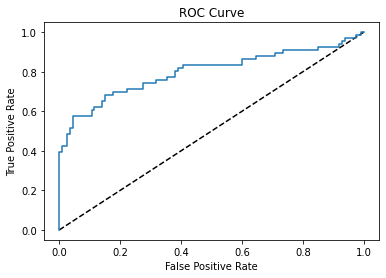

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, threshold = roc_curve(Y_test, predict_test_proba)

import matplotlib.pyplot as plt

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [37]:
print('AUC  : ', roc_auc_score(Y_test, predictions_test))

AUC  :  0.747385358004827


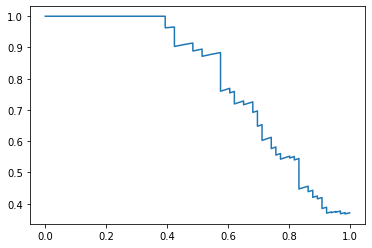

In [39]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(Y_test, predict_test_proba)

plt.plot(recall, precision)
plt.show()

In [41]:
from sklearn.metrics import log_loss

print("log-loss                    : " , log_loss(Y_test, predict_test_proba))
print("Error Rate                  : " , 1- accuracy_score(Y_test, predictions_test))

log-loss                    :  0.5033320314070904
Error Rate                  :  0.22346368715083798
